In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from labellines import labelLine, labelLines

In [2]:
benchmark_results = [
    pd.read_csv(path)
    for path in glob.glob('../benchmarks/min_entries/2020-12-08-min_entries*.csv')
]
raw_benchmark_results = pd.concat(benchmark_results)

raw_benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,min_entries,micros_input,micros_precompute,micros_until_len,micros_edit_script
946,45,remove,5500,0.666667,0,zipf,0,0,mpi_no_master_min_entries,16,1000,1723,0,178671,713
972,94,addremove,10000,1.000000,1,zipf,0,0,mpi_no_master_min_entries,8,20,2648,0,141761,1180
182,25,add,3250,0.666667,0,zipf,0,0,mpi_no_master_min_entries,8,60,1542,0,18050,178
634,48,remove,5500,0.666667,1,zipf,0,0,mpi_no_master_min_entries,8,1000,1595,0,208511,470
820,1,remove,1000,0.333333,0,zipf,0,0,mpi_no_master_min_entries,8,100,1237,0,20705,134


In [3]:
indexed_benchmark_results = raw_benchmark_results.set_index(['generation_config_i', 'repetition_i', 'min_entries', 'mpi_procs'])
indexed_benchmark_results

input_strategy  \
generation_config_i repetition_i min_entries mpi_procs                  
89                  0            20          8                    add   
                    1            20          8                    add   
                    0            60          8                    add   
                    1            60          8                    add   
                    0            100         8                    add   
...                                                               ...   
48                  1            200         16                remove   
                    0            500         16                remove   
                    1            500         16                remove   
                    0            1000        16                remove   
                    1            1000        16                remove   

                                                        input_length_1  \
generation_config_i repetition_i min_entries mpi_procs                   
89                  0            20          8                   10000   
                    1            20          8                   10000   
                    0            60          8                   10000   
                    1            60          8                   10000   
                    0            100         8                   10000   
...                                                                ...   
48                  1            200         16                   5500   
                    0            500         16                   5500   
                    1            500         16                   5500   
                    0            1000        16                   5500   
                    1            1000        16                   5500   

                                                        input_change_strength  \
generation_config_i repetition_i min_entries mpi_procs                          
89                  0            20          8                       1.000000   
                    1            20          8                       1.000000   
                    0            60          8                       1.000000   
                    1            60          8                       1.000000   
                    0            100         8                       1.000000   
...                                                                       ...   
48                  1            200         16                      0.666667   
                    0            500         16                      0.666667   
                    1            500         16                      0.666667   
                    0            1000        16                      0.666667   
                    1            1000        16                      0.666667   

                                                        input_chunkiness  \
generation_config_i repetition_i min_entries mpi_procs                     
89                  0            20          8                         0   
                    1            20          8                         0   
                    0            60          8                         0   
                    1            60          8                         0   
                    0            100         8                         0   
...                                                                  ...   
48                  1            200         16                        1   
                    0            500         16                        1   
                    1            500         16                        1   
                    0            1000        16                        1   
                    1            1000        16                        1   

                                                       input_distribution  \
generation_config_i re

In [54]:
unique_mpi_procs = sorted(np.unique(indexed_benchmark_results.index.get_level_values('mpi_procs').values))
unique_mpi_procs

[8, 16]

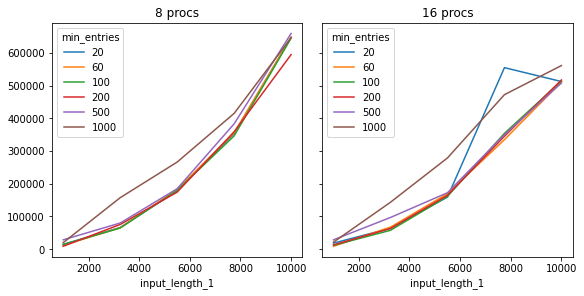

In [66]:
# Overall speed of different min_entries
fig, ax = plt.subplots(1,len(unique_mpi_procs), figsize=(8, 4), sharey='row', sharex=True, constrained_layout=True)
for mpi_procs in unique_mpi_procs:
    temp = indexed_benchmark_results.groupby(['generation_config_i', 'min_entries', 'mpi_procs']).min()
    temp = temp[(temp['input_strategy'] == 'independent')]
    temp = temp.xs(mpi_procs, level='mpi_procs')
    temp = temp.set_index('input_length_1', append=True)
    temp = temp.unstack('min_entries')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()

    plot_idx = unique_mpi_procs.index(mpi_procs)  
    temp.plot(ax=ax[plot_idx], legend=True, title=f"{mpi_procs} procs");

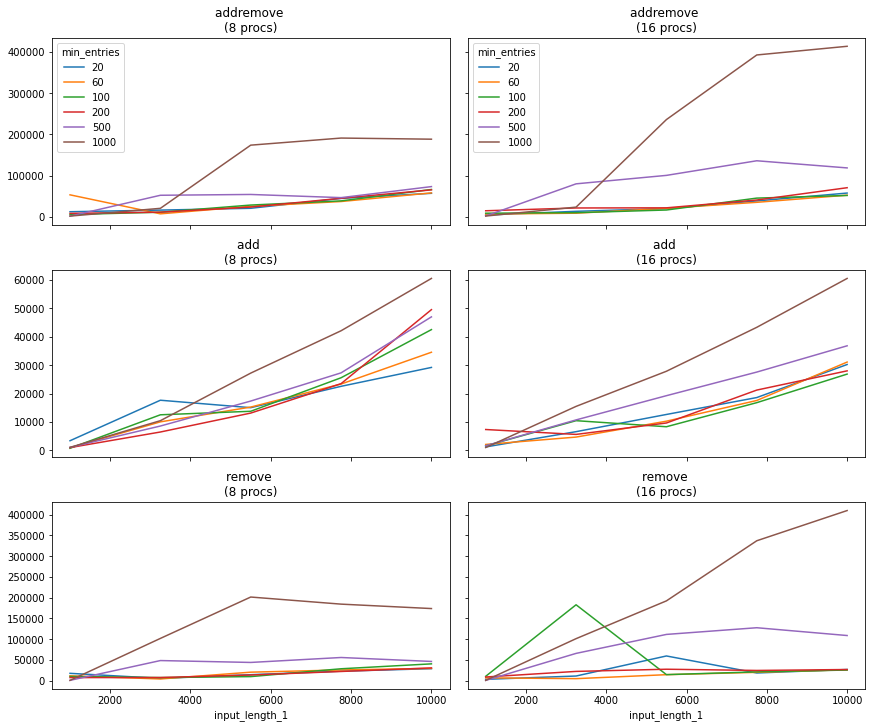

In [48]:
# Breakdown of performance by input strategy
fig, ax = plt.subplots(3,len(unique_mpi_procs), figsize=(12, 10), sharex=True, sharey='row', constrained_layout=True)
for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
    for mpi_procs in unique_mpi_procs:
        temp = indexed_benchmark_results.groupby(['generation_config_i', 'min_entries', 'mpi_procs']).min()
        temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)]
        temp = temp.set_index('input_length_1', append=True)
        temp = temp.xs(mpi_procs, level='mpi_procs')
        temp = temp.unstack('min_entries')['micros_until_len']
        temp = temp.droplevel('generation_config_i')
        temp = temp.sort_index()

        plot_idx = unique_mpi_procs.index(mpi_procs)  
        temp.plot(ax=ax[input_strategy_i][plot_idx], legend=(input_strategy_i == 0), title=(input_strategy + f" \n({mpi_procs} procs)"));

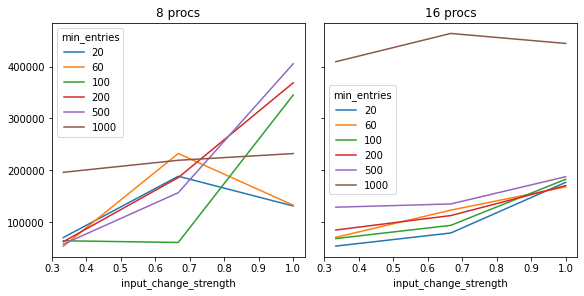

In [72]:
# min_entries performance for largest input_change_strenght and chunkiness
fig, ax = plt.subplots(1,len(unique_mpi_procs), figsize=(8, 4), sharey='row', sharex=True, constrained_layout=True)
for mpi_procs in unique_mpi_procs:
    temp = indexed_benchmark_results.groupby(['generation_config_i', 'min_entries', 'mpi_procs']).min()
    temp = temp[(temp['input_strategy'] == 'addremove') & (temp['input_length_1'] == temp['input_length_1'].max()) & (temp['input_chunkiness'] == 1)]
    temp = temp.xs(mpi_procs, level='mpi_procs')
    temp = temp.set_index('input_change_strength', append=True)
    temp = temp.unstack('min_entries')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()

    plot_idx = unique_mpi_procs.index(mpi_procs)  
    temp.plot(ax=ax[plot_idx], legend=True, title=f"{mpi_procs} procs");